# 1.Импорт библиотек и загрузка данных

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, f_oneway
from geopy.distance import geodesic as GD
from scipy.stats import shapiro
from sklearn.preprocessing import LabelEncoder

# Импортируем библиотеки для визуализации,
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# для отбора признаков,
from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif # anova

In [2]:
hotels = pd.read_csv('data/hotels.csv')
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


Первоначальная версия датасета содержит 17 полей со следующей информацией:

* hotel_address — адрес отеля;
* review_date — дата, когда рецензент разместил соответствующий отзыв;
* average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* hotel_name — название отеля;
* reviewer_nationality — страна рецензента;
* negative_review — отрицательный отзыв, который рецензент дал отелю;
* review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
* positive_review — положительный отзыв, который рецензент дал отелю;
* review_total_positive_word_counts — общее количество слов в положительном отзыве.
* reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
* total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
* total_number_of_reviews — общее количество действительных отзывов об отеле;
* tags — теги, которые рецензент дал отелю;
* days_since_review — количество дней между датой проверки и датой очистки;
* additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat — географическая широта отеля;
* lng — географическая долгота отеля.

In [3]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

# 2. Работа с признаками

In [4]:
# категориальные признаки
cat_cols = [s for s in hotels.columns if hotels[s].dtypes == 'object']
# непрерывные признаки
num_cols = [s for s in hotels.columns if hotels[s].dtypes != 'object']
display('Категориальные признаки:', cat_cols)
display('Непрерывные признаки:', num_cols)

'Категориальные признаки:'

['hotel_address',
 'review_date',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'positive_review',
 'tags',
 'days_since_review']

'Непрерывные признаки:'

['additional_number_of_scoring',
 'average_score',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'reviewer_score',
 'lat',
 'lng']

In [5]:
# Количество уникальных отелей
unique_hotels = hotels['hotel_name'].nunique()
unique_addresses = hotels['hotel_address'].nunique()

print(f"Количество уникальных названий отелей: {unique_hotels}")
print(f"Количество уникальных адресов отелей: {unique_addresses}")

Количество уникальных названий отелей: 1492
Количество уникальных адресов отелей: 1493


In [6]:
# Выбираем только строковые колонки
string_columns = hotels.select_dtypes(include=['object']).columns
print("Строковые колонки:", list(string_columns))

# Посмотрим на уникальные значения в каждой строковой колонке
for column in string_columns:
    print(f"\n--- {column} ---")
    print("Уникальных значений:", hotels[column].nunique())
    print("Примеры значений:")
    print(hotels[column].value_counts().head())

Строковые колонки: ['hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'tags', 'days_since_review']

--- hotel_address ---
Уникальных значений: 1493
Примеры значений:
hotel_address
163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom              3587
372 Strand Westminster Borough London WC2R 0JJ United Kingdom                     3206
Westminster Bridge Road Lambeth London SE1 7UT United Kingdom                     3095
Scarsdale Place Kensington Kensington and Chelsea London W8 5SY United Kingdom    2688
7 Pepys Street City of London London EC3N 4AF United Kingdom                      2379
Name: count, dtype: int64

--- review_date ---
Уникальных значений: 731
Примеры значений:
review_date
8/2/2017     1911
9/15/2016    1738
4/5/2017     1702
8/30/2016    1462
2/16/2016    1451
Name: count, dtype: int64

--- hotel_name ---
Уникальных значений: 1492
Примеры значений:
hotel_name
Britannia International Hotel Cana

Строковые колонки:
* hotel_address
* review_date
* hotel_name
* reviewer_nationality
* negative_review
* positive_review
* tags
* days_since_review

Колонка review_date представляет собой дату.

In [7]:
# Преобразуем в datetime
hotels['review_date'] = pd.to_datetime(hotels['review_date'])

# Когда был оставлен самый свежий отзыв
freshest_review = hotels['review_date'].max()
print("Cамый свежий отзыв:", freshest_review)

# Когда был оставлен самый первый отзыв
first_eview = hotels['review_date'].min()
print("Самый первый отзыв:", first_eview)

# Преобразуем признак в формат даты, чтобы извлечь месяц, когда был оставлен отзыв
hotels['season'] = pd.to_datetime(hotels['review_date']).dt.month

# Напишем функцию для определения сезона
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    return 'Autumn'
    
hotels['season'] = hotels['season'].apply(get_season)
hotels['season'].value_counts()

hotels.drop(columns=['review_date'], axis=1, inplace=True)  

Cамый свежий отзыв: 2017-08-03 00:00:00
Самый первый отзыв: 2015-08-04 00:00:00


In [8]:
hotels['hotel_address'].value_counts()

hotel_address
163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom              3587
372 Strand Westminster Borough London WC2R 0JJ United Kingdom                     3206
Westminster Bridge Road Lambeth London SE1 7UT United Kingdom                     3095
Scarsdale Place Kensington Kensington and Chelsea London W8 5SY United Kingdom    2688
7 Pepys Street City of London London EC3N 4AF United Kingdom                      2379
                                                                                  ... 
Via Palmanova 153 20132 Milan Italy                                                  7
40 Rue Rene Boulanger 10th arr 75010 Paris France                                    7
Via M Buonarroti 13 Fiera Milano City 20149 Milan Italy                              6
Johann Staud Stra e 32 16 Ottakring 1160 Vienna Austria                              6
13 Rue Fran ois Ory 92120 Paris France                                               5
Name: count, Length: 1493, dt

In [9]:
# Создадим функцию для извлечения страны из признака
def get_country(address):
    country = address.split()[-1]
    if country == 'Kingdom':
        return 'United Kingdom'
    else:
        return country

In [10]:
hotels['country'] = hotels['hotel_address'].apply(get_country)
hotels['country'].value_counts()

country
United Kingdom    196774
Spain              45132
France             44830
Netherlands        43006
Austria            29178
Italy              27883
Name: count, dtype: int64

In [11]:
# Создадим функцию для извлечения города из признака
def get_city(address):
    if address.split()[-1] == 'Kingdom':
        return address.split()[-5]
    else:
        return address.split()[-2]

In [12]:
hotels['city'] = hotels['hotel_address'].apply(get_city)
hotels['city'].value_counts()

city
London       196774
Barcelona     45132
Paris         44830
Amsterdam     43006
Vienna        29178
Milan         27883
Name: count, dtype: int64

In [13]:
hotels['negative_review'].value_counts().iloc[:30]

negative_review
No Negative            95907
 Nothing               10737
 Nothing                3154
 nothing                1660
 N A                     802
 None                    737
                         606
 N a                     384
 Breakfast               296
 Small room              283
 Location                281
 All good                251
 Everything              251
 Nothing really          240
 none                    223
 nothing                 219
 No complaints           201
 Nil                     197
 Nothing really          195
 Price                   192
 n a                     176
 Nothing to dislike      159
 Nothing at all          154
 Nothing at all          139
 Small rooms             135
 None                    134
 No complaints           129
 All good                116
 NA                      109
 Expensive               105
Name: count, dtype: int64

Видим по распределению, что многие отзывы на самом деле не являются негативными, необходимо очистить от них наш признак. Перед очисткой приведём их к единому виду - удалим лишние пробелы и уберём верхний регистр.

In [14]:
# Преобразование признака "negative_review"
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.strip().lower())

In [15]:
# Создадим список выражений, которые попали в ложноотрицательные отзывы
no_negative = [
    'no negative', 'nothing','n a', 'na', 'none', ' ', 'nothing really', 
    'all good', 'no complaints', 'nothing at all', 'nothing at all', 
    'nil', 'everything was perfect', 'absolutely nothing','everything was great',
    'nothing to complain about', 'no', 'nothing not to like' 
    ]
hotels['non_negative'] = hotels['negative_review'].apply(
    lambda x: 0 if x in no_negative else 1)
hotels['non_negative'].value_counts()

non_negative
1    269417
0    117386
Name: count, dtype: int64

In [16]:
# Преобразование признака "positive_review"
hotels['positive_review'].value_counts().iloc[:30]

positive_review
No Positive            26885
 Location               6833
 Everything             1697
 location               1251
 Nothing                 931
 The location            830
 Great location          809
 Good location           690
 Location                663
 Breakfast               455
 Everything              449
 Friendly staff          385
 Staff                   347
 Excellent location      296
 Great location          280
 Location and staff      256
 everything              233
 Good location           214
 Nothing                 170
 nothing                 159
 Comfy bed               158
 The location            152
 good location           151
 The staff               151
 the location            141
 Location was good       140
 Location was great      137
 Location staff          136
 Good breakfast          130
                         128
Name: count, dtype: int64

In [17]:
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: x.strip().lower())

In [18]:
no_positive = [
    'no positive', 'nothing'
    ]
hotels['non_positive'] = hotels['positive_review'].apply(
    lambda x: 0 if x in no_positive else 1)
hotels['non_positive'].value_counts()

non_positive
1    358621
0     28182
Name: count, dtype: int64

In [19]:
# Преобразование признака "tags"
hotels['tags'].value_counts()

tags
[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                                                              3853
[' Leisure trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                                                     3673
[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                                                     3274
[' Leisure trip ', ' Couple ', ' Deluxe Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                                                       2964
[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']                                                             2454
                                                                                                                                                 

In [20]:
# Разбиваем все теги на отдельные и создаем плоский список
all_tags = hotels['tags'].str.strip("[]").str.replace("'", "").str.split(", ").explode().str.strip()

# Удаляем пустые строки и считаем уникальные
unique_tags_count = all_tags[all_tags != ''].nunique()
print(f"Количество уникальных тегов: {unique_tags_count}")

Количество уникальных тегов: 2368


In [21]:
# Считаем частоту каждого тега
tag_counts = pd.Series(all_tags).value_counts()

# Находим самый частый тег
most_common_tag = tag_counts.index[0]
most_common_count = tag_counts.iloc[0]

print(f"Самый частый тег: '{most_common_tag}'")
print()
print(f"Количество отзывов с этим тегом: {most_common_count}")
print()
print(f"Наиболее популярные теги:\n{tag_counts.head(6)}")


Самый частый тег: 'Leisure trip'

Количество отзывов с этим тегом: 313593

Наиболее популярные теги:
tags
Leisure trip                      313593
Submitted from a mobile device    230778
Couple                            189212
Stayed 1 night                    145373
Stayed 2 nights                   100263
Solo traveler                      81235
Name: count, dtype: int64


In [22]:
# Цель поездки 
# ~ 10 000 тыс. рецензентов не указали цель поездки
trip_reg = 'Leisure|Business' # используем регулярное выражение
hotels['trip'] = hotels['tags'].str.findall(trip_reg).str.get(0)
# тех, кто не указал цель поездки определим в группу "Other"
hotels.trip = hotels.trip.apply(lambda x: 'Other' if (x != 'Leisure') & (x != 'Business') else x) 
hotels.trip.value_counts()

trip
Leisure     313593
Business     62007
Other        11203
Name: count, dtype: int64

In [23]:
# Способ подтверждения
hotels['confirmation'] = hotels['tags'].apply(
    lambda x: 1 if 'Submitted from a mobile device' in x else 0)
hotels['confirmation'].value_counts()

confirmation
1    230778
0    156025
Name: count, dtype: int64

In [24]:
# Фильтруем теги, связанные с продолжительностью пребывания
stay_tags = [tag for tag in all_tags if 'night' in tag.lower() or 'ноч' in tag.lower()]

# Считаем частоту тегов с продолжительностью пребывания
stay_tag_counts = pd.Series(stay_tags).value_counts()

print("Теги с продолжительностью пребывания:")
for tag, count in stay_tag_counts.items():
    print(f"'{tag}': {count} отзывов")

Теги с продолжительностью пребывания:
'Stayed 1 night': 145373 отзывов
'Stayed 2 nights': 100263 отзывов
'Stayed 3 nights': 72000 отзывов
'Stayed 4 nights': 35748 отзывов
'Stayed 5 nights': 15611 отзывов
'Stayed 6 nights': 7399 отзывов
'Stayed 7 nights': 5549 отзывов
'Stayed 8 nights': 1910 отзывов
'Stayed 9 nights': 966 отзывов
'Stayed 10 nights': 663 отзывов
'Stayed 11 nights': 306 отзывов
'Stayed 12 nights': 217 отзывов
'Stayed 14 nights': 184 отзывов
'Stayed 13 nights': 174 отзывов
'Stayed 15 nights': 87 отзывов
'Stayed 16 nights': 38 отзывов
'Stayed 17 nights': 27 отзывов
'Stayed 18 nights': 24 отзывов
'Stayed 19 nights': 23 отзывов
'Stayed 21 nights': 19 отзывов
'Stayed 20 nights': 17 отзывов
'Stayed 27 nights': 10 отзывов
'Stayed 30 nights': 10 отзывов
'King Room with Knightsbridge View': 8 отзывов
'Stayed 22 nights': 8 отзывов
'Stayed 28 nights': 7 отзывов
'Special Offer Double Room 3 nights minimum': 6 отзывов
'Stayed 23 nights': 6 отзывов
'Stayed 26 nights': 6 отзывов
'Stayed

In [25]:
# Длительность проживания
# Для извлечения признака из списка используем регулярные выражения
stayed_reg = 'Stayed\s([\d]*)'
hotels['days_stayed'] = hotels['tags'].str.findall(stayed_reg).str.get(0)
# Дополним недостающие данные модальным значением
hotels['days_stayed'] = hotels['days_stayed'].fillna(hotels['days_stayed'].mode()[0])
# Преобразуем тип данных в числовой
hotels['days_stayed'] = hotels['days_stayed'].astype('int64')
# Пользователей, которые останавливались на больше 7 дней определим в отдельную категорию
# и в дальнейшем закодируем признак, как категориальный
hotels['days_stayed'] = hotels['days_stayed'].apply(lambda x: 'long_stay' if x > 7 else x)
hotels['days_stayed'].value_counts()

# Преобразуем столбец в числовой тип, обработав возможные ошибки
hotels['days_stayed'] = pd.to_numeric(hotels['days_stayed'], errors='coerce')

# Проверим, есть ли пропущенные значения после преобразования
print(hotels['days_stayed'].isnull().sum())

# Теперь можем применять функцию
hotels['days_stayed_cat'] = hotels['days_stayed'].apply(
    lambda x: 'long_stay' if x > 7 else f'{int(x)}_nights' if pd.notnull(x) else 'unknown'
)

# Удаляем исходный столбец
hotels = hotels.drop('days_stayed', axis=1)

4714


In [26]:
# Количество людей
count_reg = 'Solo|Couple|Group|Family with older children|Family with young children'
hotels['group_type'] = hotels['tags'].str.findall(count_reg).str.get(0)
hotels['group_type'] = hotels['group_type'].fillna('Other')
hotels['group_type'] = hotels['group_type'].apply(lambda x: 'Family' if 'Family' in x else x)
hotels['group_type'].value_counts()

group_type
Couple    189212
Solo       81235
Family     65638
Group      49088
Other       1630
Name: count, dtype: int64

In [27]:
# Преобразование признака "days_since_review"
hotels['days_since_review'].value_counts()

days_since_review
1 days     1911
322 day    1738
120 day    1702
338 day    1462
534 day    1451
           ... 
122 day     154
243 day     154
615 day     146
124 day     127
123 day     111
Name: count, Length: 731, dtype: int64

In [28]:
days_reg = '\d{1,3}'
hotels['days_since_review'] = hotels['days_since_review'].str.findall(days_reg).str.get(0)
hotels['days_since_review'] = hotels['days_since_review'].astype('int64')

Сделаем предположение, что отзывы, оставленные менее года назад более актуальны, выведем их в отдельный признак.

In [29]:
hotels['left_within_year'] = hotels['days_since_review'].apply(
    lambda x: 1 if x < 365 else 0)
hotels['left_within_year'].value_counts()

left_within_year
1    200724
0    186079
Name: count, dtype: int64

In [30]:
hotels.drop(columns=['days_since_review'], axis=1, inplace=True) 

In [31]:
# Преобразование признака "Lat" и "Lng"
# Проверим текущие типы данных
print("Типы данных до преобразования:")
print(f"lat: {hotels['lat'].dtype}")
print(f"lng: {hotels['lng'].dtype}")

# Посмотрим на несколько примеров значений
print("\nПримеры значений:")
print(hotels[['lat', 'lng']].head())

# если тип object - выполним преобразование
if hotels['lat'].dtype == 'object':
    print("\nВыполняем преобразование...")
    hotels['lat'] = pd.to_numeric(hotels['lat'].str.replace(',', '.'), errors='coerce')
    hotels['lng'] = pd.to_numeric(hotels['lng'].str.replace(',', '.'), errors='coerce')
    print("Преобразование завершено")
    
    # проверим результат
    print(f"\nТипы данных после преобразования:")
    print(f"lat: {hotels['lat'].dtype}")
    print(f"lng: {hotels['lng'].dtype}")

Типы данных до преобразования:
lat: float64
lng: float64

Примеры значений:
         lat       lng
0  51.507894 -0.143671
1  51.521009 -0.123097
2  48.845377  2.325643
3  48.888697  2.394540
4  52.385601  4.847060


In [32]:
# Смотрим пропуски по городам
cities_with_missing = hotels[hotels['lat'].isnull() | hotels['lng'].isnull()]['city'].value_counts()
print("Города с пропущенными координатами:")
print(cities_with_missing)

# Уникальные отели с пропусками
hotels_with_missing = hotels[hotels['lat'].isnull() | hotels['lng'].isnull()]['hotel_name'].nunique()
print(f"\nУникальных отелей с пропущенными координатами: {hotels_with_missing}")

Города с пропущенными координатами:
city
Vienna       1990
Paris         299
Barcelona     159
Name: count, dtype: int64

Уникальных отелей с пропущенными координатами: 17


Данные пропущены по 3 городам всего в 17 отелях, для заполнения пропусков воспользуемся индексами отелей и библиотекой pgeocode

In [33]:
Par_mask = hotels['city'] == 'Paris'
Barc_mask = hotels['city'] == 'Barcelona'
Vien_mask = hotels['city'] == 'Vienna'
# Выведем медианные значения долготы и широты по Парижу, Барселоне и Вене
lat_Par = hotels[Par_mask]['lat'].median()
lng_Par = hotels[Par_mask]['lng'].median()
lat_Barc = hotels[Barc_mask]['lat'].median()
lng_Barc = hotels[Barc_mask]['lng'].median()
lat_Vien = hotels[Vien_mask]['lat'].median()
lng_Vien = hotels[Vien_mask]['lng'].median()
# Значения, которые будем вставлять
Par_values = {'lat' : lat_Par, 'lng' : lng_Par}
Barc_values = {'lat' : lat_Barc, 'lng' : lng_Barc}
Vien_values = {'lat' : lat_Vien, 'lng' : lng_Vien}
# Заполняем пропущенные значения
hotels[Par_mask] = hotels[Par_mask].fillna(Par_values)
hotels[Barc_mask] = hotels[Barc_mask].fillna(Barc_values)
hotels[Vien_mask] = hotels[Vien_mask].fillna(Vien_values)

In [34]:
# Убедимся, что пропущенных значений больше не осталось
hotels.isnull().mean()

hotel_address                                 0.0
additional_number_of_scoring                  0.0
average_score                                 0.0
hotel_name                                    0.0
reviewer_nationality                          0.0
negative_review                               0.0
review_total_negative_word_counts             0.0
total_number_of_reviews                       0.0
positive_review                               0.0
review_total_positive_word_counts             0.0
total_number_of_reviews_reviewer_has_given    0.0
reviewer_score                                0.0
tags                                          0.0
lat                                           0.0
lng                                           0.0
season                                        0.0
country                                       0.0
city                                          0.0
non_negative                                  0.0
non_positive                                  0.0


Сами по себе координаты отеля не представляют ценности для модели, попробуем извлечь из них что нибудь полезное, например, удалённость от центра города. Для этого воспользуемся библиотекой geopy.

In [35]:
# Создадим DataFrame с координатами центров городов, где находятся отели
centers = pd.DataFrame(data=[
    ['London', 51.51, -0.13], 
    ['Paris', 48.85, 2.35],
    ['Vienna', 48.21, 16.37],
    ['Amsterdam', 52.37, 4.89],
    ['Barcelona', 41.39, 2.16], 
    ['Milan', 45.46, 9.19]],
    columns = ['city', 'center_lat', 'center_lng']  
    )   
# Выделим отдельный датафрейм с координатами отелей и 
# объединим его с датафреймом координат центров
hotels_short = hotels[['hotel_address', 'city', 'lat', 'lng']].drop_duplicates()
hotels_short = hotels_short.merge(centers, on='city', how='left')
# Напишем функцию, которая будет высчитывать расстояние до центра города
def get_distance(center_lat, center_lng, lat, lng):
   return round(GD([center_lat, center_lng], [lat, lng]).km, 2)
# Применим функцию к новому датафрейму
hotels_short['center_distance'] = hotels_short.apply(
    lambda x: get_distance(x['center_lng'], 
    x['center_lat'], x['lng'], x['lat']), axis=1)
# Перед объединением с основным датасетом удалим лишние признаки, 
# чтобы у нас остались только название отеля и расстояние до центра
hotels_short = hotels_short.drop(columns = [
    'city', 'center_lat', 'center_lng', 'lat', 'lng'], axis=1)
# Осталось объединить полученный признак с основным датасетом
hotels = hotels.merge(hotels_short, on='hotel_address', how='left')

In [36]:
# Создадим отдельный признак с отелями в центре города
hotels['is_center'] = hotels['center_distance'].apply(lambda x: 1 if x <= 1.5 else 0)
hotels.is_center.value_counts()

is_center
0    296371
1     90432
Name: count, dtype: int64

Оценим, насколько расположение в центре коррелирует с положительным отзывом о локации отеля.

In [37]:
# Выведем количество положительных отзывов о локации отеля
display(hotels['positive_review'].str.contains('location').value_counts().loc[True])
# Посмотрим, сколько отелей с положительными отзывами о локации расположены в центре
hotels[hotels['positive_review'].str.contains('location')]['is_center'].value_counts()

np.int64(142044)

is_center
0    98905
1    43139
Name: count, dtype: int64

30,4% положительных отзывов связаны с отелями, которые расположены в центре.
Добавим признак "good_location".

In [38]:
hotels['good_location'] = hotels['positive_review'].str.contains('location')
hotels['good_location'] = hotels['good_location'].apply(lambda x: 1 if x == True else 0)

In [39]:
# Выведем топ-10 отелей, получивших наибольшее количество положительных отзывов о расположении
hotels.groupby('hotel_name')['positive_review'].count().sort_values(
    ascending = False).iloc[:10]

hotel_name
Britannia International Hotel Canary Wharf           3587
Strand Palace Hotel                                  3206
Park Plaza Westminster Bridge London                 3095
Copthorne Tara Hotel London Kensington               2688
DoubleTree by Hilton Hotel London Tower of London    2379
Grand Royale London Hyde Park                        2218
Holiday Inn London Kensington                        2097
Hilton London Metropole                              1982
Intercontinental London The O2                       1939
Millennium Gloucester Hotel London                   1889
Name: positive_review, dtype: int64

In [40]:
# Преобразование признака "hotel_name"
hotels['hotel_name'].value_counts().iloc[:10]

hotel_name
Britannia International Hotel Canary Wharf           3587
Strand Palace Hotel                                  3206
Park Plaza Westminster Bridge London                 3095
Copthorne Tara Hotel London Kensington               2688
DoubleTree by Hilton Hotel London Tower of London    2379
Grand Royale London Hyde Park                        2218
Holiday Inn London Kensington                        2097
Hilton London Metropole                              1982
Intercontinental London The O2                       1939
Millennium Gloucester Hotel London                   1889
Name: count, dtype: int64

In [41]:
# Составляем список c наименованиями сетей отелей
hotel_chains = ['Ibis', 'Best Western', 'Holiday Inn', 'Mercure', 'Premier Inn',
                    'Novotel', 'Hilton', 'NH', 'Travelodge', 'Four Seasons', 'Hyatt',
                    'InterContinental', 'Kempinski', 'Lotte', 'Marriott', 'Ritz',
                    'Millennium', 'Copthorne', 'Radisson', 'Wyndham', 'Accor', 'Whitbread',
                    'Melia', 'Louvre', 'TUI', 'Carlson', 'Motel One'
                    ]
# Напишем функцию, которая будет проверять принадлежность отеля к сети
def is_chain(hotel):
    for h in hotel_chains:
        if h.lower() in hotel.lower():
            return 1
    return 0

In [42]:
hotels['is_chain'] = hotels['hotel_name'].apply(is_chain)
hotels['is_chain'].value_counts()

is_chain
0    285089
1    101714
Name: count, dtype: int64

In [43]:
# НОВОЕ

# Удалим текстовые колонки после извлечения из них информации
hotels = hotels.drop(['negative_review', 'positive_review', 'tags', 
                      'hotel_address', 'hotel_name'], axis=1)

In [44]:
# Преобразование признака "reviewer_nationality"
hotels['reviewer_nationality'].value_counts().iloc[:15]

reviewer_nationality
United Kingdom               184033
United States of America      26541
Australia                     16239
Ireland                       11126
United Arab Emirates           7617
Saudi Arabia                   6722
Netherlands                    6608
Switzerland                    6498
Canada                         5984
Germany                        5956
France                         5543
Israel                         4918
Italy                          4562
Belgium                        4529
Turkey                         4105
Name: count, dtype: int64

In [45]:
# Сократим количество национальностей, выделим топ-10 национальности, остальных объединим в группу "Other"
most_freq_nat = hotels['reviewer_nationality'].value_counts().nlargest(10)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(
    lambda x: x if x in most_freq_nat else 'Other') 

In [46]:
# Воспользуемся методом np.where, чтобы создать признак, 
# в котором страна отеля совпадает со страной пользователя
# но перед этим удалим лишние пробелы в национальности пользователей
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x.strip())
hotels['is_citizen'] = np.where(hotels['country'] == hotels['reviewer_nationality'], 1, 0)
hotels['is_citizen'].value_counts()

is_citizen
0    257424
1    129379
Name: count, dtype: int64

При анализе отзывов мы выяснили, что они содержали много ложноположительных и ложноотрицательных отзывов, это, в свою очередь, исказило признаки с количеством слов в отрицательных и положительных отзывах. Давайте исправим это.

In [47]:
# Преобразование признаков "review_total_negative_word_counts" и "review_total_positive_word_counts"
# Обнулим количество слов в негативном отзыве в тех строках, где их на самом деле нет
mask = (hotels['non_negative'] == 0)
hotels.loc[mask, 'review_total_negative_word_counts'] = hotels.loc[
    mask, 'review_total_negative_word_counts'].apply(lambda x: 0 if x > 0 else x)
# Повторим то же самое для положительных отзывов
mask = (hotels['non_positive'] == 0)
hotels.loc[mask, 'review_total_positive_word_counts'] = hotels.loc[
    mask, 'review_total_positive_word_counts'].apply(lambda x: 0 if x > 0 else x)

In [48]:
# Преобразование признака "additional_number_of_scoring"
hotels[['additional_number_of_scoring', 'total_number_of_reviews']]

,additional_number_of_scoring,total_number_of_reviews
0,581,1994
1,299,1361
2,32,406
3,34,607
4,914,7586
...,...,...
386798,107,617
386799,272,3224
386800,457,2751
386801,365,1567


In [49]:
hotels['non_review_ratio'] = round(1 - hotels['additional_number_of_scoring'] / 
    hotels['total_number_of_reviews'], 2)

In [50]:
hotels.drop(columns=['additional_number_of_scoring', 'total_number_of_reviews'], axis=1, inplace=True) 

Построим несколько столбчатых диаграмм, чтобы посмотреть на то, как распределены оставшиеся нечисловые признаки, и как они соотносятся с целевым показателем.

Как и было отмечено на этапе знакомства с данными, большинство непрерывных признаков имеет распределение, отличное от нормального, однако распределение двух признаков всё же похоже на нормальное - это созданный нами признак 'non_review_ratio' и признак, который мы отмечали ранее - 'average_score'.
Для определения характера распределения воспользуемся методом Шапиро.

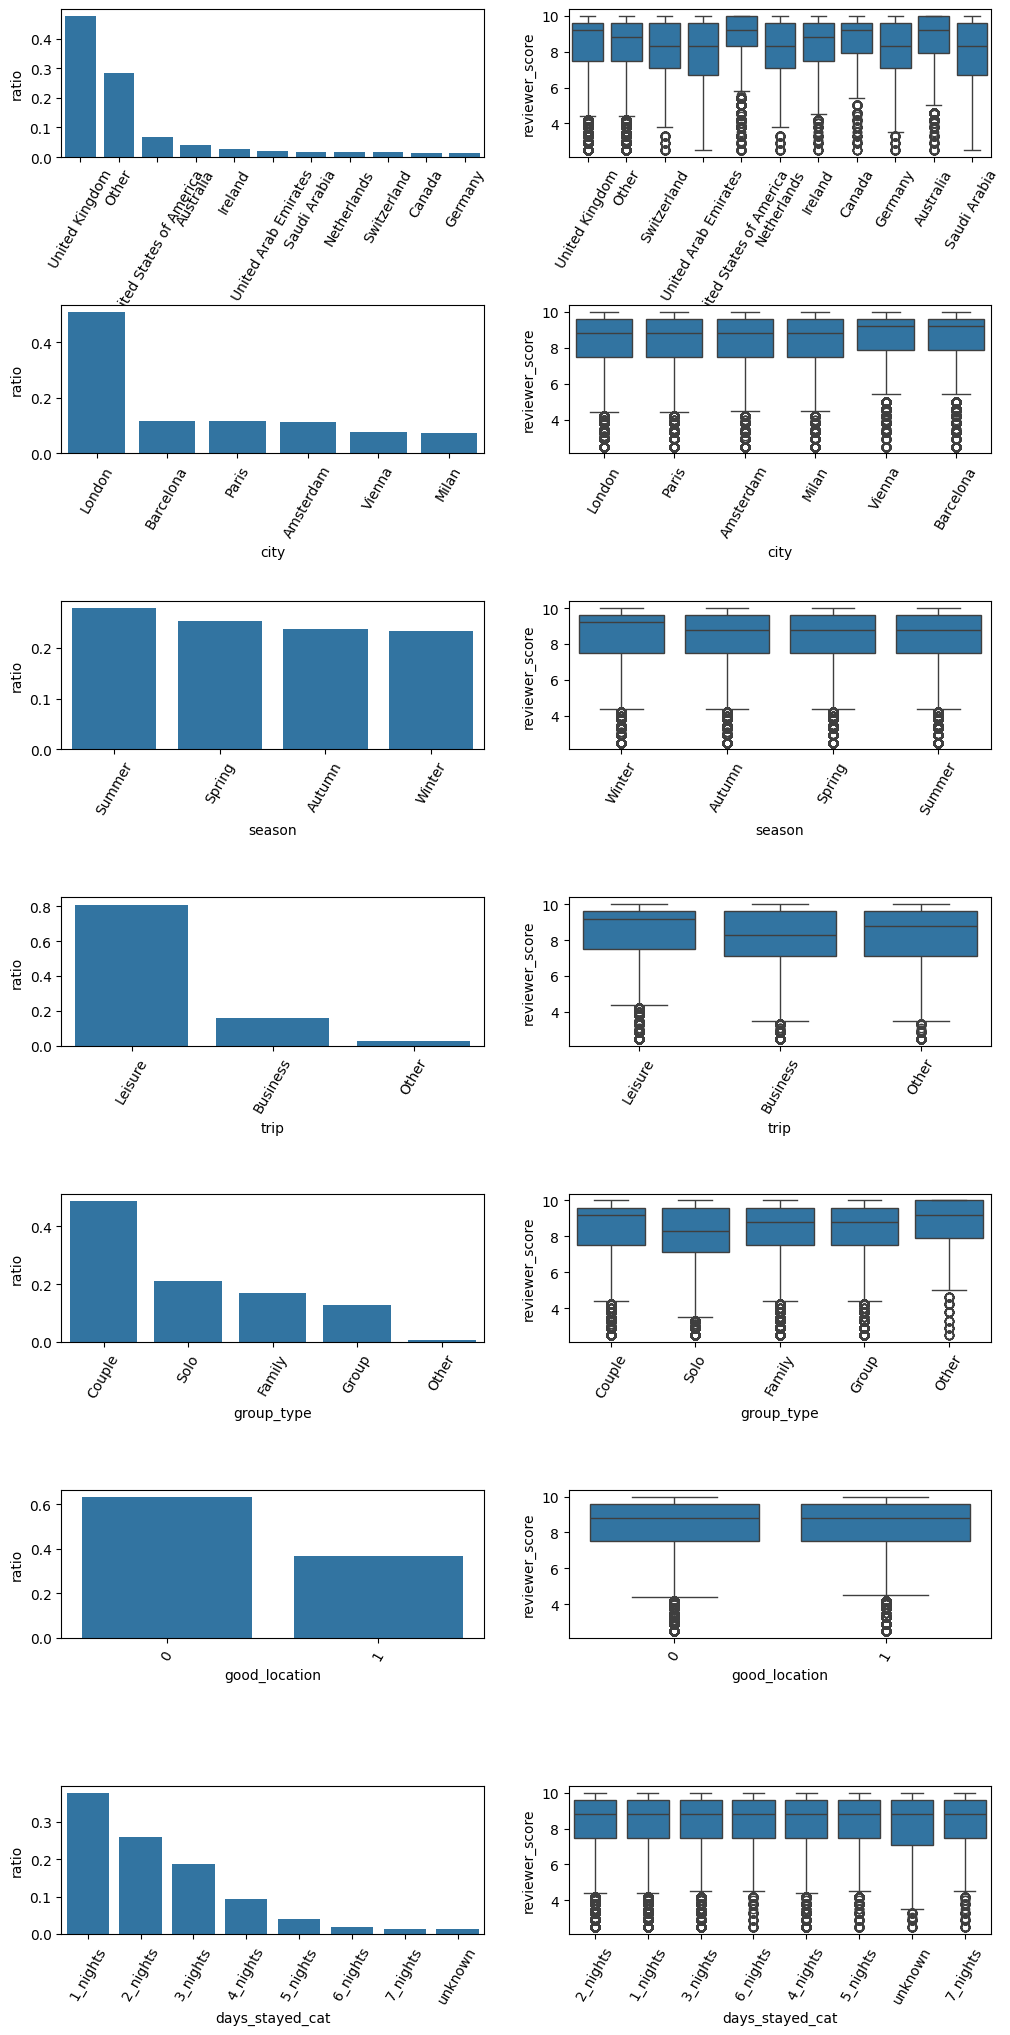

In [51]:
# Создадим список интересующих нас категориальных признаков
cat_cols = [
 'reviewer_nationality',
 'city',
 'season',
 'trip',
 'group_type', 'good_location', 'days_stayed_cat']
n = len(cat_cols)

fig, axes = plt.subplots(n, 2, figsize=(12, 25))
# Создадим цикл для построения графиков каждого признака
for i, feature in enumerate(cat_cols):
    cat_count = hotels[feature].value_counts(normalize=True).sort_values(
                ascending=False).rename('ratio').reset_index()
    cat_count.columns = [feature, 'ratio']
    ratio_barplot = sns.barplot(
        data=cat_count, 
        x=feature, 
        y='ratio', 
        ax=axes[i][0]
        )
    ratio_barplot.xaxis.set_tick_params(rotation=60)

    main_boxplot = sns.boxplot(
        data=hotels,
        x=feature,
        y='reviewer_score',
        ax = axes[i][1]
        )
    main_boxplot.xaxis.set_tick_params(rotation=60)
    
fig.subplots_adjust(hspace=1.0)

In [52]:
alpha = 0.05 # уровень значимости
# Рассчитаем p-value для признака non_review_ratio и сравним с уровнем статистической значимости
_, p_value_1 = shapiro(hotels['non_review_ratio'])
print('p-value non_review_ratio: {}'.format(p_value_1))
if p_value_1 < alpha:
    print('Распределение non_review_ratio отлично от нормального')
else:
    print('Распределение non_review_ratio нормальное')
# Рассчитаем p-value для признака average_score и сравним с уровнем статистической значимости
_, p_value_2 = shapiro(hotels['average_score'])
print('p-value average_score: {}'.format(p_value_2))
if p_value_2 < alpha:
    print('Распределение average_score отлично от нормального')
else:
    print('Распределение average_score нормальное')

p-value non_review_ratio: 6.6578914684400835e-112
Распределение non_review_ratio отлично от нормального
p-value average_score: 1.1668287481539683e-95
Распределение average_score отлично от нормального


c:\Users\alesh\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 386803.
  res = hypotest_fun_out(*samples, **kwds)


Оба распределения отличны от нормального, ни один из числовых признаков не имеет нормального распределения

Найдено 17 числовых признаков


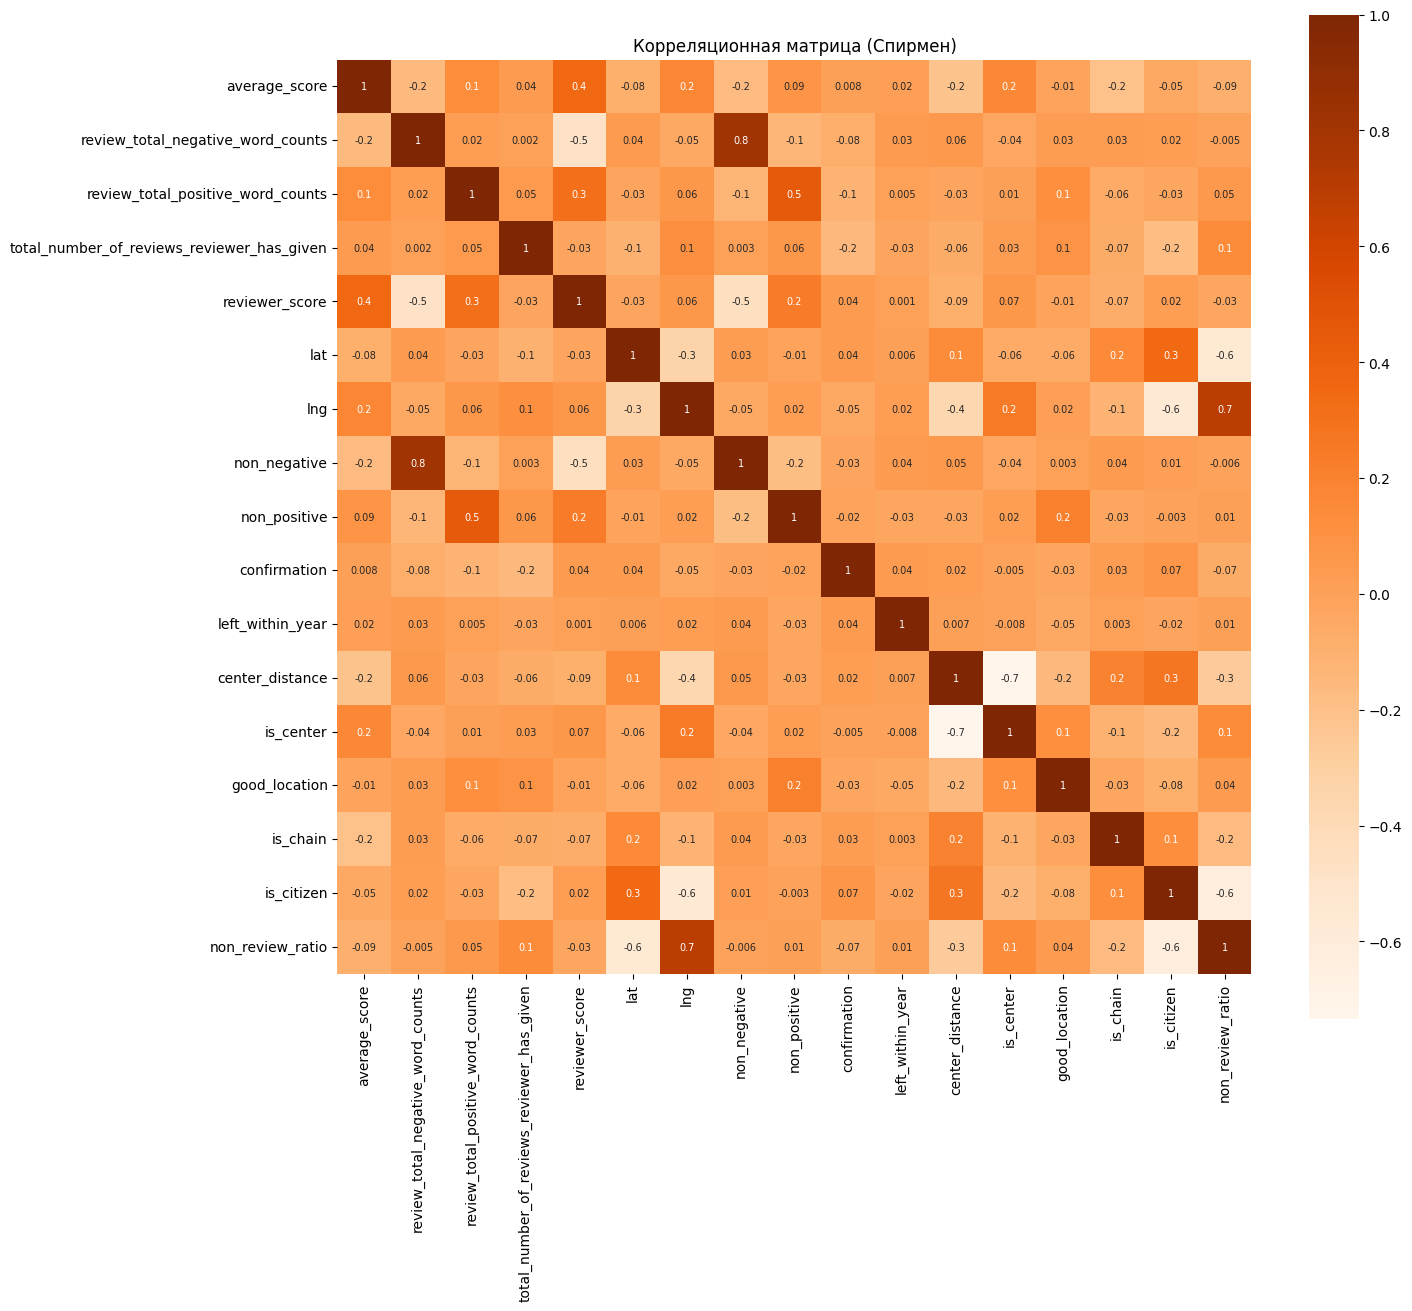

In [53]:
# Сначала определим числовые колонки
numeric_cols = hotels.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"Найдено {len(numeric_cols)} числовых признаков")

# Создаем DataFrame с числовыми признаками
num_features_df = hotels[numeric_cols]

# Считаем корреляцию Спирмена
corr = num_features_df.corr(method='spearman')

# Визуализация
plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, fmt='.1g', annot_kws={"size":7}, cmap='Oranges', 
            square=True, cbar_kws={"shrink": 0.8})
plt.title('Корреляционная матрица (Спирмен)')
plt.tight_layout()
plt.show()

# 3. Проверка значимости признаков

Допустим, наша целевая переменная — reviewer_score (рейтинг отеля от рецензента).
Если мы хотим использовать хи-квадрат для категориальных признаков против категориальной целевой, нужно преобразовать reviewer_score в категориальную переменную. Например, разделим на "низкий" и "высокий" рейтинг.

In [54]:
# Создадим бинарный признак на основе медианы reviewer_score
median_score = hotels['reviewer_score'].median()
hotels['score_binary'] = (hotels['reviewer_score'] >= median_score).astype(int)

In [55]:
cat_cols = hotels.select_dtypes(include=['object']).columns.tolist()
print(f"Найдено {len(numeric_cols)} категориальных признаков")


Найдено 17 категориальных признаков


In [56]:
# Применение хи-квадрат
# Определим категориальные колонки
cat_cols = hotels.select_dtypes(include=['object']).columns.tolist()
print(f"Найдено {len(numeric_cols)} категориальных признаков")

chi2_results = []
for col in cat_cols:
    # Создаем таблицу сопряженности
    contingency_table = pd.crosstab(hotels[col], hotels['score_binary'])
    # Выполняем тест хи-квадрат
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi2_results.append((col, chi2, p))

# Преобразуем результаты в DataFrame
chi2_df = pd.DataFrame(chi2_results, columns=['Feature', 'Chi2', 'p-value'])
chi2_df = chi2_df.sort_values(by='p-value')
chi2_df.head(20)

Найдено 17 категориальных признаков


,Feature,Chi2,p-value
0,reviewer_nationality,4572.235100,0.000000e+00
4,trip,4056.112784,0.000000e+00
6,group_type,2638.872882,0.000000e+00
2,country,974.351891,2.144886e-208
3,city,974.351891,2.144886e-208
1,season,452.828752,7.949664e-98
5,days_stayed_cat,155.404846,2.970247e-30


In [57]:
# Применение ANOVA
# Определим непрерывные колонки
num_cols = hotels.select_dtypes(include=['int64', 'int32', 'float64', 'float32']).columns.tolist()
print(f"Найдено {len(num_cols)} непрерывных признаков")

anova_results = []
for col in num_cols:
    # Группируем по бинарному таргету
    group1 = hotels[hotels['score_binary'] == 0][col].dropna()
    group2 = hotels[hotels['score_binary'] == 1][col].dropna()
    # Выполняем ANOVA
    f_stat, p_val = f_oneway(group1, group2)
    anova_results.append((col, f_stat, p_val))

anova_df = pd.DataFrame(anova_results, columns=['Feature', 'F-statistic', 'p-value'])
anova_df = anova_df.sort_values(by='p-value')
anova_df.head(20)

Найдено 18 непрерывных признаков


c:\Users\alesh\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


,Feature,F-statistic,p-value
0,average_score,4.752008e+04,0.000000e+00
14,is_chain,1.973385e+03,0.000000e+00
12,is_center,1.563313e+03,0.000000e+00
7,non_negative,6.468341e+04,0.000000e+00
8,non_positive,1.562117e+04,0.000000e+00
2,review_total_positive_word_counts,1.604722e+04,0.000000e+00
1,review_total_negative_word_counts,3.987795e+04,0.000000e+00
4,reviewer_score,7.381628e+05,0.000000e+00
17,score_binary,inf,0.000000e+00
11,center_distance,9.977268e+02,1.066283e-218


In [58]:
# Вывод результатов
print("Top significant categorical features (Chi-square):")
print(chi2_df.head(10))
print("\nTop significant numeric features (ANOVA):")
print(anova_df.head(10))

Top significant categorical features (Chi-square):
                Feature         Chi2        p-value
0  reviewer_nationality  4572.235100   0.000000e+00
4                  trip  4056.112784   0.000000e+00
6            group_type  2638.872882   0.000000e+00
2               country   974.351891  2.144886e-208
3                  city   974.351891  2.144886e-208
1                season   452.828752   7.949664e-98
5       days_stayed_cat   155.404846   2.970247e-30

Top significant numeric features (ANOVA):
                              Feature   F-statistic        p-value
0                       average_score  4.752008e+04   0.000000e+00
14                           is_chain  1.973385e+03   0.000000e+00
12                          is_center  1.563313e+03   0.000000e+00
7                        non_negative  6.468341e+04   0.000000e+00
8                        non_positive  1.562117e+04   0.000000e+00
2   review_total_positive_word_counts  1.604722e+04   0.000000e+00
1   review_total_nega

In [59]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 25 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               386803 non-null  float64
 1   reviewer_nationality                        386803 non-null  object 
 2   review_total_negative_word_counts           386803 non-null  int64  
 3   review_total_positive_word_counts           386803 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 5   reviewer_score                              386803 non-null  float64
 6   lat                                         386803 non-null  float64
 7   lng                                         386803 non-null  float64
 8   season                                      386803 non-null  object 
 9   country                                     386803 non-null  object 
 

# 4. Разделение набора данных

In [60]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели
# Х — данные с информацией об отелях, у — целевая переменная (рейтинги отелей)
X = hotels.drop(['reviewer_score'], axis = 1)
y = hotels['reviewer_score']

# Простая очистка - оставляем только числовые столбцы
X_numeric = X.select_dtypes(include=[np.number])
print(f"Исходно столбцов: {X.shape[1]}, после очистки: {X_numeric.shape[1]}")

# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" — для тестирования.
# Для тестирования мы будем использовать 25 % от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.25, random_state=42)

Исходно столбцов: 24, после очистки: 17


# 5. Создание и обучение модели

In [61]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

# 6. Оценка качества модели

In [62]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test) и смотрим, насколько они отличаются
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений в отношении фактических.
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.09229150144192547
